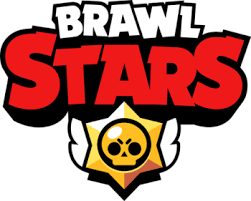

## Brawl Stars Data Science - Predict a win or loss for top players - Fetch the battle data

This script connects with the official Brawl Stars API and retrieves various info about a player's latest matches with the purpose of designing an ML algorithm that will be able to predict if a match will end as a win or loss.

In [1]:
# Install Libraries
!pip install brawlstats

In [2]:
# Import libraries
import brawlstats
import numpy as np
import pandas as pd
from datetime import datetime

# Import functions
from parameters import *  # Change to parameters_template and add your API KEY.
from utils.duplicate_battles import *
from utils.save_battles import *

In [3]:
# Connect with the client using your unique token
client = brawlstats.Client(api_token)

In [4]:
countries = ['world', 'us', 'gb', 'fr', 'de', 'br', 'es', 'it', 'sg', 'jp', 
             'cn', 'at', 'au', 'dk', 'ca', 'pr', 'kr', 'ru', 'hk', 'my', 'ua',
             'ch', 'in', 'mx', 'ar', 'gr', 'ml', 'cl', 'nz'] 

In [5]:
# Get IDs of top players in the world
ids = pd.DataFrame(columns=['name','ID'])
for country in countries:
    top_players = client.get_rankings(ranking='players', region=country, limit=200)
    for player in top_players:
        temp_df = pd.DataFrame(data=np.array([player.name, player.tag]).reshape((1,2)),
                               columns=['name','ID'])
        ids = pd.concat([ids, temp_df])
        
ids.drop_duplicates(keep='first', inplace=True)

ids.reset_index(drop=True, inplace=True)

In [6]:
ids = ids.tail(3500)

In [7]:
ids

,name,ID
2155,BS|⛈️乙乇尺ㄖᵏⁱˡˡˢㄩ,#Q2L89LL
2156,SaͥllͣyͫBliZziツ,#9GU2J0Q98
2157,Mͥuxͣxͫiᵍᵒᵈ🦋,#YY08VJ98
2158,笑|🌧Rᴀᴡ☺️ˡᵐᵃᵒ,#U00GUJPR
2159,dani #1_yt,#2JGVRQLGP
...,...,...
5650,⭐solarRay⭐,#89QPVCJ
5651,🇹🇷Memoli82☣,#2PRVRJVJ
5652,bmkey,#8UJ2GGL2
5653,Бро,#P8RJRJPP2


In [8]:
all_data = pd.DataFrame(columns=df_columns)

In [9]:
# For each player, retrieve their match history

for i in ids['ID']:
    
    # Prints for loop
    print('')
    print('**** Scanning player no {} out of {} ****'.format(ids[ids['ID']==i].index[0]+1, len(ids)))
    print('Name: {}, ID: {}'.format(ids[ids['ID']==i].loc[ids[ids['ID']==i].index[0]]['name'], i))
    
    try:
        # Get all the battles for a player
        battles = client.get_battle_logs(i)
        
    except:
        print('This ID is not recognised and will be skipped.')
        continue
    
    # Loop the battles of a player
    for j in range(0,len(battles.raw_data)):
        
        # Check if battle is valid
        valid_battle = True
        
        # First Level of Filtering
        # Not include Boss Fight
        if battles.raw_data[j]['battle']['mode'] == 'bossFight':
            valid_battle = False
        # Not include Robo Rumble
        if battles.raw_data[j]['battle']['mode'] == 'roboRumble':
            valid_battle = False
        # Not include Big Game
        if battles.raw_data[j]['battle']['mode'] == 'bigGame':
            valid_battle = False
        
        # Second Level of Filtering ("type" key is available)
        if valid_battle:
            # Not include friendly battles
            if battles.raw_data[j]['battle']['type'] == 'friendly':
                valid_battle = False
            # Not include tournament battles
            if battles.raw_data[j]['battle']['type'] == 'tournament':
                valid_battle = False
            # Not include Solo Showdown
            if battles.raw_data[j]['battle']['mode'] == 'soloShowdown':
                valid_battle = False
            # Not include Duo Showdown
            if battles.raw_data[j]['battle']['mode'] == 'duoShowdown':
                valid_battle = False
            # All event info should be available
            if len(battles.raw_data[j]['event']) != 3:
                valid_battle = False
        
        # Populate a placeholder df (battle_df) with all the battle information
        if valid_battle:

            # Store the info for the specific battle
            battle_df = pd.DataFrame(data = np.zeros((1,len(df_columns))), columns=df_columns)

            # General
            battle_df['timestamp'] = battles.raw_data[j]['battleTime']
            battle_df['event_id'] = battles.raw_data[j]['event']['id']
            battle_df['mode'] = battles.raw_data[j]['event']['mode']
            battle_df['map'] = battles.raw_data[j]['event']['map']
            battle_df['type'] = battles.raw_data[j]['battle']['type']
            # battle_df['result'] = battles.raw_data[j]['battle']['result']
            
            # Figure out if player is in team 1 or 2
            id_in_team_1 = False
            for k in range(0,3):
                if i == battles.raw_data[j]['battle']['teams'][0][k]['tag']:
                    id_in_team_1 = True
            # battle_df['id_in_tm1'] = id_in_team_1

            # Player specific
            battle_df['pl1_tm1_brawler'] = battles.raw_data[j]['battle']['teams'][0][0]['brawler']['name']
            battle_df['pl1_tm1_brwlr_trop'] = battles.raw_data[j]['battle']['teams'][0][0]['brawler']['trophies']
            battle_df['pl1_tm1_brwlr_pwr'] = battles.raw_data[j]['battle']['teams'][0][0]['brawler']['power']

            battle_df['pl2_tm1_brawler'] = battles.raw_data[j]['battle']['teams'][0][1]['brawler']['name']
            battle_df['pl2_tm1_brwlr_trop'] = battles.raw_data[j]['battle']['teams'][0][1]['brawler']['trophies']
            battle_df['pl2_tm1_brwlr_pwr'] = battles.raw_data[j]['battle']['teams'][0][1]['brawler']['power']

            battle_df['pl3_tm1_brawler'] = battles.raw_data[j]['battle']['teams'][0][2]['brawler']['name']
            battle_df['pl3_tm1_brwlr_trop'] = battles.raw_data[j]['battle']['teams'][0][2]['brawler']['trophies']
            battle_df['pl3_tm1_brwlr_pwr'] = battles.raw_data[j]['battle']['teams'][0][2]['brawler']['power']

            battle_df['pl1_tm2_brawler'] = battles.raw_data[j]['battle']['teams'][1][0]['brawler']['name']
            battle_df['pl1_tm2_brwlr_trop'] = battles.raw_data[j]['battle']['teams'][1][0]['brawler']['trophies']
            battle_df['pl1_tm2_brwlr_pwr'] = battles.raw_data[j]['battle']['teams'][1][0]['brawler']['power']

            battle_df['pl2_tm2_brawler'] = battles.raw_data[j]['battle']['teams'][1][1]['brawler']['name']
            battle_df['pl2_tm2_brwlr_trop'] = battles.raw_data[j]['battle']['teams'][1][1]['brawler']['trophies']
            battle_df['pl2_tm2_brwlr_pwr'] = battles.raw_data[j]['battle']['teams'][1][1]['brawler']['power']

            battle_df['pl3_tm2_brawler'] = battles.raw_data[j]['battle']['teams'][1][2]['brawler']['name']
            battle_df['pl3_tm2_brwlr_trop'] = battles.raw_data[j]['battle']['teams'][1][2]['brawler']['trophies']
            battle_df['pl3_tm2_brwlr_pwr'] = battles.raw_data[j]['battle']['teams'][1][2]['brawler']['power']

            # Check if team 1 won
            tm1_win = False
            if (id_in_team_1 == True) and (battles.raw_data[j]['battle']['result'] == 'victory'):
                tm1_win = True
            if (id_in_team_1 == False) and (battles.raw_data[j]['battle']['result'] == 'defeat'):
                tm1_win = True

            battle_df['tm1_win'] = tm1_win
            
            # Add this battle to the df with all the battles
            all_data = pd.concat([all_data, battle_df])
            
            all_data.reset_index(drop=True, inplace=True)


**** Scanning player no 2156 out of 3500 ****
Name: BS|⛈️乙乇尺ㄖᵏⁱˡˡˢㄩ, ID: #Q2L89LL

**** Scanning player no 2157 out of 3500 ****
Name: SaͥllͣyͫBliZziツ, ID: #9GU2J0Q98

**** Scanning player no 2158 out of 3500 ****
Name: Mͥuxͣxͫiᵍᵒᵈ🦋, ID: #YY08VJ98

**** Scanning player no 2159 out of 3500 ****
Name: 笑|🌧Rᴀᴡ☺️ˡᵐᵃᵒ, ID: #U00GUJPR

**** Scanning player no 2160 out of 3500 ****
Name: dani #1_yt, ID: #2JGVRQLGP

**** Scanning player no 2161 out of 3500 ****
Name: pat, ID: #C9LY8L9P

**** Scanning player no 2162 out of 3500 ****
Name: win is mine, ID: #R90CJ0

**** Scanning player no 2163 out of 3500 ****
Name: ʳᵘᵗʰˡᵉˢˢAlina, ID: #8G9YRPRJP

**** Scanning player no 2164 out of 3500 ****
Name: ⛩ᵒⁿˡʸNOAHᵍᵒᵈ🎋, ID: #R2L980Q8

**** Scanning player no 2165 out of 3500 ****
Name: КОСТЯН4ИК, ID: #8QCVYP2QV

**** Scanning player no 2166 out of 3500 ****
Name: 🍌BäņäňäBøý🍌, ID: #RP9LR020

**** Scanning player no 2167 out of 3500 ****
Name: Julian 10, ID: #Y998LQLL

**** Scanning player no 2168 out of 3


**** Scanning player no 2256 out of 3500 ****
Name: Phoenix, ID: #80R82920U

**** Scanning player no 2257 out of 3500 ****
Name: Ghost_Flo, ID: #82GCJLV08
This ID is not recognised and will be skipped.

**** Scanning player no 2258 out of 3500 ****
Name: Gabel_#1, ID: #2Y80RC800

**** Scanning player no 2259 out of 3500 ****
Name: Fraunz 1, ID: #GC98VCVJ

**** Scanning player no 2260 out of 3500 ****
Name: Totem, ID: #2R2Y2JUG0

**** Scanning player no 2261 out of 3500 ****
Name: BB | Isaar, ID: #20LJ29ULR

**** Scanning player no 2262 out of 3500 ****
Name: DorniYT, ID: #RU9Y09YY

**** Scanning player no 2263 out of 3500 ****
Name: Jedi mind, ID: #2JG9C2QC8

**** Scanning player no 2264 out of 3500 ****
Name: RS|JERRY, ID: #CY8889

**** Scanning player no 2265 out of 3500 ****
Name: RAV⚡ELI, ID: #8CPU2GLCP

**** Scanning player no 2266 out of 3500 ****
Name: ☆Uwe_YT☆, ID: #C2U2YCUR

**** Scanning player no 2267 out of 3500 ****
Name: Superhünchen6.0, ID: #8P0LQRJP0

**** Scanning pla


**** Scanning player no 2358 out of 3500 ****
Name: Бюджет, ID: #2CUPC8UVQ

**** Scanning player no 2359 out of 3500 ****
Name: MasterMango, ID: #2RGUUUUV

**** Scanning player no 2360 out of 3500 ****
Name: Sr Abduzcan, ID: #2CUVRQ0JJ

**** Scanning player no 2361 out of 3500 ****
Name: Avarice ^_^, ID: #2J9PJVQG2

**** Scanning player no 2362 out of 3500 ****
Name: ᴠʟᴀᴅ シ︎, ID: #PQ29P0YV

**** Scanning player no 2363 out of 3500 ****
Name: M𝖆xø𝔣𝔣, ID: #8CLLUV88Y

**** Scanning player no 2364 out of 3500 ****
Name: EpicEvan7|YT, ID: #28PG2PPP

**** Scanning player no 2365 out of 3500 ****
Name: 🍀|Irish🥀, ID: #CR0GGY9J
This ID is not recognised and will be skipped.

**** Scanning player no 2366 out of 3500 ****
Name: jp/gamer, ID: #2RP28G8P9

**** Scanning player no 2367 out of 3500 ****
Name: RedChicoFresa, ID: #9UUJU220V

**** Scanning player no 2368 out of 3500 ****
Name: Riyadh King, ID: #88Q9QPJU9

**** Scanning player no 2369 out of 3500 ****
Name: zNetWarrior, ID: #VLJYRQC

***


**** Scanning player no 2459 out of 3500 ****
Name: Y-ONG, ID: #8P2VCRRLP

**** Scanning player no 2460 out of 3500 ****
Name: ninja23, ID: #LV08J0GG

**** Scanning player no 2461 out of 3500 ****
Name: Toc夜影, ID: #99VG9RRV0

**** Scanning player no 2462 out of 3500 ****
Name: YT: Bagelz BS, ID: #8GUV98R8Q

**** Scanning player no 2463 out of 3500 ****
Name: 🌌DarkВanan🌌, ID: #PQP0V980L

**** Scanning player no 2464 out of 3500 ****
Name: Pͥsyͣcͫho͛tͣiͩc, ID: #9L98LUVC

**** Scanning player no 2465 out of 3500 ****
Name: Rosé, ID: #8RCVR0PVU

**** Scanning player no 2466 out of 3500 ****
Name: Gabby🥀 ツ ᴷⁱˡˡ, ID: #8LY29RVPV

**** Scanning player no 2467 out of 3500 ****
Name: Pi Family, ID: #9JRQUJCY2

**** Scanning player no 2468 out of 3500 ****
Name: lapis lazuli, ID: #CGVR2GVU

**** Scanning player no 2469 out of 3500 ****
Name: Megan, ID: #Q2JYUYVU

**** Scanning player no 2470 out of 3500 ****
Name: Святая Мадонна, ID: #8YLG8QUU2

**** Scanning player no 2471 out of 3500 ****
Name


**** Scanning player no 2560 out of 3500 ****
Name: RedNinja, ID: #89Q29LLP

**** Scanning player no 2561 out of 3500 ****
Name: CSN|Ahmad⚡, ID: #8PR8LCPUR

**** Scanning player no 2562 out of 3500 ****
Name: Chrislampa, ID: #9QGQCYJG

**** Scanning player no 2563 out of 3500 ****
Name: ♡₱ıθnͫэяScøя﷼`, ID: #V92CV28P

**** Scanning player no 2564 out of 3500 ****
Name: BLUE ANGEL, ID: #8J8VJUJR

**** Scanning player no 2565 out of 3500 ****
Name: GIB|Prego, ID: #9CQ82RC2L

**** Scanning player no 2566 out of 3500 ****
Name: AborreTossen64⛩, ID: #9JPVJP08Q

**** Scanning player no 2567 out of 3500 ****
Name: Gullermeister, ID: #8CQ2JL8QG

**** Scanning player no 2568 out of 3500 ****
Name: philkiller, ID: #9RVU9CGJP

**** Scanning player no 2569 out of 3500 ****
Name: Les Casas^_^, ID: #8RPC0ULV

**** Scanning player no 2570 out of 3500 ****
Name: き⚪️た歯科インプラント, ID: #2U88P992G

**** Scanning player no 2571 out of 3500 ****
Name: Хочу умереть, ID: #YYLVVGVQ

**** Scanning player no 2572 o


**** Scanning player no 2662 out of 3500 ****
Name: Muh Fahmi 🇲🇨, ID: #2YY2Q02

**** Scanning player no 2663 out of 3500 ****
Name: $TORM BRE@KER⚒️, ID: #R2QVJ08U

**** Scanning player no 2664 out of 3500 ****
Name: TOT_LUIS, ID: #22YU0LJ2

**** Scanning player no 2665 out of 3500 ****
Name: Lord_Vivter, ID: #9J9YYRJR

**** Scanning player no 2666 out of 3500 ****
Name: rookies79, ID: #Q0GJCJLP

**** Scanning player no 2667 out of 3500 ****
Name: duddy❤️❤️, ID: #8RYYVCRLL

**** Scanning player no 2668 out of 3500 ****
Name: EK, ID: #U2LJUG8J

**** Scanning player no 2669 out of 3500 ****
Name: Brawl Star, ID: #92U9P8YLR

**** Scanning player no 2670 out of 3500 ****
Name: Omar Khalluf, ID: #VJ8CC0U0
This ID is not recognised and will be skipped.

**** Scanning player no 2671 out of 3500 ****
Name: SørenShow, ID: #RCY2UL2C

**** Scanning player no 2672 out of 3500 ****
Name: henker, ID: #2PR0CUQ2L

**** Scanning player no 2673 out of 3500 ****
Name: mr sugerør, ID: #8LL2CGYQ8

**** Sca


**** Scanning player no 2762 out of 3500 ****
Name: diwen:(, ID: #2VPR8U9CQ

**** Scanning player no 2763 out of 3500 ****
Name: Lukiebearᛏ, ID: #8R2V0P0

**** Scanning player no 2764 out of 3500 ****
Name: Suburito, ID: #GVL9CYJG

**** Scanning player no 2765 out of 3500 ****
Name: 4T|Stevegamer, ID: #2GLG90G9R
This ID is not recognised and will be skipped.

**** Scanning player no 2766 out of 3500 ****
Name: YT: Arshan01, ID: #99LU80RRY

**** Scanning player no 2767 out of 3500 ****
Name: OneTrickᵇᵃᵇʸ, ID: #2R8J80G0

**** Scanning player no 2768 out of 3500 ****
Name: michi, ID: #UP20VGV

**** Scanning player no 2769 out of 3500 ****
Name: Toxic Dissen 🖤, ID: #99QVY20LY

**** Scanning player no 2770 out of 3500 ****
Name: A̸7̸A̸G̸⇘, ID: #99JQQRCJ

**** Scanning player no 2771 out of 3500 ****
Name: Shia LaBeouf, ID: #GVJ8R2CJ

**** Scanning player no 2772 out of 3500 ****
Name: DSR |L●rd $mT, ID: #2C8RRR2Q

**** Scanning player no 2773 out of 3500 ****
Name: Ynetic胜💫, ID: #9QPR9822



**** Scanning player no 2863 out of 3500 ****
Name: gavin, ID: #UQRC200Q

**** Scanning player no 2864 out of 3500 ****
Name: ❄️|PRiNGLES™, ID: #VLPP9QVQ

**** Scanning player no 2865 out of 3500 ****
Name: Kœmmÿ Bøõ, ID: #8Q889LCL

**** Scanning player no 2866 out of 3500 ****
Name: bogodo, ID: #JU0VUVCY

**** Scanning player no 2867 out of 3500 ****
Name: ฬaͥᴋyͣzͫᵍᵒᵈ🥀, ID: #CYPGQRQ

**** Scanning player no 2868 out of 3500 ****
Name: ETChan, ID: #RLUJU2GV

**** Scanning player no 2869 out of 3500 ****
Name: Yousef, ID: #RCULQQRP

**** Scanning player no 2870 out of 3500 ****
Name: Big Brawler, ID: #UPLPPVUP

**** Scanning player no 2871 out of 3500 ****
Name: lolurbad, ID: #PL90J0880

**** Scanning player no 2872 out of 3500 ****
Name: RavenOf8, ID: #2QL90JU0

**** Scanning player no 2873 out of 3500 ****
Name: AB|Andy, ID: #U9GUG8P

**** Scanning player no 2874 out of 3500 ****
Name: QN|HÉ1000 (2.0), ID: #P8YJV9JQQ

**** Scanning player no 2875 out of 3500 ****
Name: DEJAYX, ID: #2

This ID is not recognised and will be skipped.

**** Scanning player no 2966 out of 3500 ****
Name: 蜜McRusian🍁Niko, ID: #LG0PPJC

**** Scanning player no 2967 out of 3500 ****
Name: EG|San's Shiber, ID: #GURQ9GQL

**** Scanning player no 2968 out of 3500 ****
Name: D'Ryonツ, ID: #9PCG9Q00R

**** Scanning player no 2969 out of 3500 ****
Name: Derek, ID: #2CYVP0GRC

**** Scanning player no 2970 out of 3500 ****
Name: Topi Jr., ID: #CJ9G0JP0

**** Scanning player no 2971 out of 3500 ****
Name: XxZisquitoxX, ID: #2LPQG8QJR

**** Scanning player no 2972 out of 3500 ****
Name: PR|Wolfgamer, ID: #JY2PP0VC

**** Scanning player no 2973 out of 3500 ****
Name: 🤩🥶🤯🤩🤩, ID: #J02YY0PR

**** Scanning player no 2974 out of 3500 ****
Name: Nature, ID: #RY9GPQ8

**** Scanning player no 2975 out of 3500 ****
Name: ☔️ic¥taco😴, ID: #PVQY8UQY8

**** Scanning player no 2976 out of 3500 ****
Name: 🥀¥λZ₦łEŁ🌹❦, ID: #RPV8GYQV

**** Scanning player no 2977 out of 3500 ****
Name: DreamSlash, ID: #8QYUQQVC

**** Sca


**** Scanning player no 3067 out of 3500 ****
Name: JellyPhonix, ID: #2U9L09UUP

**** Scanning player no 3068 out of 3500 ****
Name: jrthekiller, ID: #JPGRCYV9

**** Scanning player no 3069 out of 3500 ****
Name: ＭＡＴＨＥＷ, ID: #QL22LUJR

**** Scanning player no 3070 out of 3500 ****
Name: HDF|Julieta_21, ID: #2GRU9RUQR

**** Scanning player no 3071 out of 3500 ****
Name: JoeJoe, ID: #2UPGVYQ
This ID is not recognised and will be skipped.

**** Scanning player no 3072 out of 3500 ****
Name: Sebastiánscaban, ID: #2GYCLP28Y

**** Scanning player no 3073 out of 3500 ****
Name: HC|NoobvokHUN, ID: #28CRCL92Q

**** Scanning player no 3074 out of 3500 ****
Name: JDSTUART, ID: #UC0P99JP

**** Scanning player no 3075 out of 3500 ****
Name: GOLDEN FREEZER, ID: #PGJ9YGCQY

**** Scanning player no 3076 out of 3500 ****
Name: Ricky, ID: #G8GJLUQL

**** Scanning player no 3077 out of 3500 ****
Name: ⚡MD⚡afro🔥, ID: #28LPLCCYR
This ID is not recognised and will be skipped.

**** Scanning player no 3078 


**** Scanning player no 3166 out of 3500 ****
Name: Ph-1, ID: #LQQLVC00
This ID is not recognised and will be skipped.

**** Scanning player no 3167 out of 3500 ****
Name: Ranada, ID: #CLG8JVVV

**** Scanning player no 3168 out of 3500 ****
Name: =KoreA=히어로, ID: #P02LYVP2

**** Scanning player no 3169 out of 3500 ****
Name: GodblessU🌼, ID: #YLVJQCJ8

**** Scanning player no 3170 out of 3500 ****
Name: BP |youngwoon❣️, ID: #22RGRUQV0

**** Scanning player no 3171 out of 3500 ****
Name: Revive PaiN〤, ID: #28L9GCPQQ

**** Scanning player no 3172 out of 3500 ****
Name: Sun_램프☀️, ID: #2CCGLV2Y2

**** Scanning player no 3173 out of 3500 ****
Name: BLSHOT |vVv⛩, ID: #2YLRYGLGR

**** Scanning player no 3174 out of 3500 ****
Name: Sun_유델제자쿠즈☀️, ID: #C2UV0JYR

**** Scanning player no 3175 out of 3500 ****
Name: YAIⓂ️MA_본좌야❕, ID: #29U08PYUL

**** Scanning player no 3176 out of 3500 ****
Name: 🗡DADDYHUNTER🗡, ID: #Y92PLC2

**** Scanning player no 3177 out of 3500 ****
Name: don't be rude, ID: #PV0


**** Scanning player no 3268 out of 3500 ****
Name: ♈Påšš_sonic♈, ID: #28V9JR9VU

**** Scanning player no 3269 out of 3500 ****
Name: Ash | Felix🎵, ID: #2Q0YRR2LY

**** Scanning player no 3270 out of 3500 ****
Name: 판 꼬, ID: #9PVRYG8L8

**** Scanning player no 3271 out of 3500 ****
Name: espionage, ID: #2P9R2GRVC

**** Scanning player no 3272 out of 3500 ****
Name: 팀원구하기지쳐접습니다, ID: #9CC09CJG

**** Scanning player no 3273 out of 3500 ****
Name: K.Y.C_⚡Volt⚡, ID: #22LLJCYG8

**** Scanning player no 3274 out of 3500 ****
Name: 즉율, ID: #QC8PGV8Q

**** Scanning player no 3275 out of 3500 ****
Name: 🌌Shine_샤인🌌, ID: #8Y9LJV0JP

**** Scanning player no 3276 out of 3500 ****
Name: 밥페ᵀᴱᴬᴹ, ID: #2Y9LQ8UG9

**** Scanning player no 3277 out of 3500 ****
Name: 호아, ID: #9PC0008V8

**** Scanning player no 3278 out of 3500 ****
Name: 🇰🇷꽃가족_전드🇰🇷, ID: #R8L29C8L

**** Scanning player no 3279 out of 3500 ****
Name: ヤンゴァな🖤Haru, ID: #RQGURQ9Y

**** Scanning player no 3280 out of 3500 ****
Name: 🌊KOR|주열🌊, ID


**** Scanning player no 3370 out of 3500 ****
Name: gafanya🎍, ID: #9RCUPY98

**** Scanning player no 3371 out of 3500 ****
Name: NaVi | BBgs, ID: #V0GUCGV8

**** Scanning player no 3372 out of 3500 ****
Name: _KaRiM_⚽️⚽️, ID: #2QG8YRJLY

**** Scanning player no 3373 out of 3500 ****
Name: Mike🥀, ID: #22Y0YURQU

**** Scanning player no 3374 out of 3500 ****
Name: Лава, ID: #8R0U92P0J

**** Scanning player no 3375 out of 3500 ****
Name: QSS|Mr_Army💔, ID: #8C9RQ9900

**** Scanning player no 3376 out of 3500 ****
Name: D ᴀ N 4 ɪ ᴋ💔垃圾, ID: #Y8CYVQQ2

**** Scanning player no 3377 out of 3500 ****
Name: Chappi🦉, ID: #GJ9LY8LU

**** Scanning player no 3378 out of 3500 ****
Name: Анскил🦥, ID: #VP0QC2Q8

**** Scanning player no 3379 out of 3500 ****
Name: NaVi|MMA, ID: #8GVQPJV

**** Scanning player no 3380 out of 3500 ****
Name: DeRkO, ID: #8JQR8Y0U9

**** Scanning player no 3381 out of 3500 ****
Name: GG|EvgeKha⚡️, ID: #20GPPLLLY

**** Scanning player no 3382 out of 3500 ****
Name: CuteStalke


**** Scanning player no 3473 out of 3500 ****
Name: LS|FourtyTwoSHG, ID: #2G82PJ2QC

**** Scanning player no 3474 out of 3500 ****
Name: Samera☔, ID: #80PLC0029

**** Scanning player no 3475 out of 3500 ****
Name: $ILHAM$, ID: #200Q90CPV

**** Scanning player no 3476 out of 3500 ****
Name: ⚡little_tendy⚡, ID: #2VRQRU29G

**** Scanning player no 3477 out of 3500 ****
Name: ⭐️ Leͥgeͣnͫd ⭐️, ID: #GV8PJPRP

**** Scanning player no 3478 out of 3500 ****
Name: Tøxic 𖠌, ID: #GJPPRG8V

**** Scanning player no 3479 out of 3500 ****
Name: 無敵魔神-nana, ID: #90CUV2YQR

**** Scanning player no 3480 out of 3500 ****
Name: ❄Hayden Choi❄, ID: #YLY9R9VGP

**** Scanning player no 3481 out of 3500 ****
Name: Jeremy🥀, ID: #82UL292YU

**** Scanning player no 3482 out of 3500 ****
Name: Kanga, ID: #PQPR2GQGJ

**** Scanning player no 3483 out of 3500 ****
Name: 🎐私はEaです|黑烈和夢龍, ID: #80GP00Q8C

**** Scanning player no 3484 out of 3500 ****
Name: 𐂂Den(´▽｀)ノ♬, ID: #J0L2Q0U0

**** Scanning player no 3485 out of 350


**** Scanning player no 3575 out of 3500 ****
Name: ❦TimBro✞ 👑, ID: #U82RUYC8

**** Scanning player no 3576 out of 3500 ****
Name: ❦MilkTおい✨, ID: #JG0RU9RL

**** Scanning player no 3577 out of 3500 ****
Name: ꧁丁B genius꧂, ID: #PPU0P99YL

**** Scanning player no 3578 out of 3500 ****
Name: Pokie, ID: #R0Y0QYPU

**** Scanning player no 3579 out of 3500 ****
Name: bye, ID: #UYVG9URJ

**** Scanning player no 3580 out of 3500 ****
Name: 小龍寶寶-FAM, ID: #CGGJYU2C

**** Scanning player no 3581 out of 3500 ****
Name: CL100, ID: #J90QQCLR

**** Scanning player no 3582 out of 3500 ****
Name: gogoletsgo8284, ID: #PQYGYUYRL

**** Scanning player no 3583 out of 3500 ****
Name: MVP|🌟Hey!Max🌟, ID: #VY09LQQ9

**** Scanning player no 3584 out of 3500 ****
Name: Thiobacillus, ID: #2GULUP08V

**** Scanning player no 3585 out of 3500 ****
Name: 我的少女時代, ID: #280QLG8Y0

**** Scanning player no 3586 out of 3500 ****
Name: splash 🌊, ID: #90YPQ0J98

**** Scanning player no 3587 out of 3500 ****
Name: HeiHei❦, I


**** Scanning player no 3678 out of 3500 ****
Name: 曜 cynical 💫, ID: #CCQ0C9QJ

**** Scanning player no 3679 out of 3500 ****
Name: jonathanleem, ID: #R2JRCR8R

**** Scanning player no 3680 out of 3500 ****
Name: ISG | G`ᴏ´D🐐, ID: #VQULV800

**** Scanning player no 3681 out of 3500 ****
Name: aiman13, ID: #28G9JPJPG

**** Scanning player no 3682 out of 3500 ****
Name: CC|Bamboo, ID: #GJRYQVL0

**** Scanning player no 3683 out of 3500 ****
Name: j_zhe, ID: #CQVVUUVC

**** Scanning player no 3684 out of 3500 ****
Name: Ningg, ID: #CQ22Q8PR

**** Scanning player no 3685 out of 3500 ****
Name: TĒNTI💸, ID: #JRGY89UV

**** Scanning player no 3686 out of 3500 ****
Name: 陈俊杰, ID: #8CVJGGG8Y

**** Scanning player no 3687 out of 3500 ****
Name: nightmhong, ID: #8CYPU2VLG

**** Scanning player no 3688 out of 3500 ****
Name: Ninja Leon, ID: #90VGJGVQJ

**** Scanning player no 3689 out of 3500 ****
Name: 流星💫|小問小さな質問🌟, ID: #9YGJGLJY8

**** Scanning player no 3690 out of 3500 ****
Name: 🐞TIKKI🐞, ID:


**** Scanning player no 3780 out of 3500 ****
Name: clarence_l.218, ID: #CUPR0Q2Q

**** Scanning player no 3781 out of 3500 ****
Name: dahshark🦈, ID: #9LC0UPPJQ
This ID is not recognised and will be skipped.

**** Scanning player no 3782 out of 3500 ****
Name: Xx_FIREICE26_xX, ID: #V8V9J2GV

**** Scanning player no 3783 out of 3500 ****
Name: xPxrify_Lixxiø, ID: #89R98PUGP

**** Scanning player no 3784 out of 3500 ****
Name: 地精首領2.0, ID: #2QJQU0V9G

**** Scanning player no 3785 out of 3500 ****
Name: 嘿!OuO神殺手Hei Hei, ID: #VQQCG09Q

**** Scanning player no 3786 out of 3500 ****
Name: VS|Teostar123, ID: #GU2VL8GR

**** Scanning player no 3787 out of 3500 ****
Name: BaoKapo, ID: #GCYQQQ0V

**** Scanning player no 3788 out of 3500 ****
Name: VS|Louis, ID: #RLYCPYPY

**** Scanning player no 3789 out of 3500 ****
Name: Scarlet warrior, ID: #VUR2JJV8

**** Scanning player no 3790 out of 3500 ****
Name: ncl, ID: #RVURPRQJ

**** Scanning player no 3791 out of 3500 ****
Name: あ|Hͥacͣkͫer❄️, ID:


**** Scanning player no 3883 out of 3500 ****
Name: ★MERCY★, ID: #9UVRC9QUG

**** Scanning player no 3884 out of 3500 ****
Name: Fantomassツ, ID: #22LJCPURQ

**** Scanning player no 3885 out of 3500 ****
Name: Rubin, ID: #2QV08JYC

**** Scanning player no 3886 out of 3500 ****
Name: den4uk, ID: #2022VUQ2Q

**** Scanning player no 3887 out of 3500 ****
Name: SRN|Buzко, ID: #VGPLRCVQ

**** Scanning player no 3888 out of 3500 ****
Name: KPD|k0cm0n@vt, ID: #CVJ2LRPY

**** Scanning player no 3889 out of 3500 ****
Name: Dash_Asasin DKM, ID: #8V9PRPQ2

**** Scanning player no 3890 out of 3500 ****
Name: ᵒᵖᴠʟᴀᴅ🌴, ID: #JCPJPVYQ

**** Scanning player no 3891 out of 3500 ****
Name: UA|Rikli™️, ID: #C28QRL9

**** Scanning player no 3892 out of 3500 ****
Name: QLS|Brendon, ID: #9QRR2LL

**** Scanning player no 3893 out of 3500 ****
Name: 『Sad💔Frost』, ID: #828GUJR9C

**** Scanning player no 3894 out of 3500 ****
Name: Nick☆PLAY, ID: #GRLGCP0G

**** Scanning player no 3895 out of 3500 ****
Name: ZET,


**** Scanning player no 3985 out of 3500 ****
Name: 我|commander🥀シ, ID: #8CULV00C

**** Scanning player no 3986 out of 3500 ****
Name: ☃️|Emitt🥀, ID: #L8R0RYC

**** Scanning player no 3987 out of 3500 ****
Name: Net, ID: #9Y0JR9CCG

**** Scanning player no 3988 out of 3500 ****
Name: ExOtic:)⚽️🔞🔥, ID: #8CV2J29VV

**** Scanning player no 3989 out of 3500 ****
Name: [UKR]LIGHT LO®D, ID: #J0JCLQ2

**** Scanning player no 3990 out of 3500 ****
Name: Hasta la vista, ID: #2UYL9RUV

**** Scanning player no 3991 out of 3500 ****
Name: ⓓⓘⓢⓣⓞⓟ☔, ID: #9202UVPR0
This ID is not recognised and will be skipped.

**** Scanning player no 3992 out of 3500 ****
Name: 『NF』Crow4ik🖤, ID: #8UGJQYU0G

**** Scanning player no 3993 out of 3500 ****
Name: paradise, ID: #92PVRQ9PR

**** Scanning player no 3994 out of 3500 ****
Name: Sad Monn;(, ID: #P8UQ0PQUP

**** Scanning player no 3995 out of 3500 ****
Name: Viktоs_skоr, ID: #YPJQCYLR8

**** Scanning player no 3996 out of 3500 ****
Name: ~Master-﷼~, ID: #JV9YU


**** Scanning player no 4087 out of 3500 ****
Name: MᴿƬƦƖƘЄƦ🥀, ID: #QGQ9U9Y8

**** Scanning player no 4088 out of 3500 ****
Name: CM|SL_Goal, ID: #P28JC0UQ0

**** Scanning player no 4089 out of 3500 ****
Name: 楠良|爪ㄖ丂ㄥ乇尺, ID: #2CYJ9VCJP

**** Scanning player no 4090 out of 3500 ****
Name: Gaming guru, ID: #2UG89JQJ2

**** Scanning player no 4091 out of 3500 ****
Name: Guillaume04, ID: #QY9JVJ

**** Scanning player no 4092 out of 3500 ****
Name: ²⁹|Mr_Koroo✨🎃, ID: #L2RV9V09

**** Scanning player no 4093 out of 3500 ****
Name: DcX|Loris🐊, ID: #89G8CJJPQ

**** Scanning player no 4094 out of 3500 ****
Name: Sunny♪, ID: #2U900282R

**** Scanning player no 4095 out of 3500 ****
Name: DN|Phenomenal, ID: #8V0U0JLV

**** Scanning player no 4096 out of 3500 ****
Name: R3D4XE, ID: #QPG8LY

**** Scanning player no 4097 out of 3500 ****
Name: 『🦦Trͥyhͣrͫdシ, ID: #2PJL8JY88

**** Scanning player no 4098 out of 3500 ****
Name: Rox2.0, ID: #9JPL29ULR

**** Scanning player no 4099 out of 3500 ****
Name: 


**** Scanning player no 4187 out of 3500 ****
Name: CM|FɪɴᴅOɴᴇPɪᴇᴄᴇ, ID: #22CCG00CL

**** Scanning player no 4188 out of 3500 ****
Name: PP|Tobi 🐷, ID: #GQYG9JJC

**** Scanning player no 4189 out of 3500 ****
Name: CH|Polarwolf, ID: #20RUG2LC

**** Scanning player no 4190 out of 3500 ****
Name: [TL] Mystery01, ID: #LQVJ9YYQ
This ID is not recognised and will be skipped.

**** Scanning player no 4191 out of 3500 ****
Name: SL | babyblue, ID: #PVL9LY9Y

**** Scanning player no 4192 out of 3500 ****
Name: PixelCraft, ID: #R8LQVV0J

**** Scanning player no 4193 out of 3500 ****
Name: 『𝓚𝚊𝚘𝘳𝓲♡』♪｡, ID: #9LY229J0
This ID is not recognised and will be skipped.

**** Scanning player no 4194 out of 3500 ****
Name: LeSplif, ID: #22898VQJR

**** Scanning player no 4195 out of 3500 ****
Name: Python77, ID: #L0CV8LRU

**** Scanning player no 4196 out of 3500 ****
Name: ZH|🌊Le BOSS🌊, ID: #2G22928GR

**** Scanning player no 4197 out of 3500 ****
Name: $QK | BumBleBee, ID: #9C8GJV2PV

**** Scanning pla


**** Scanning player no 4284 out of 3500 ****
Name: LA| No Name ⚡, ID: #2GQCGLJ9Y

**** Scanning player no 4285 out of 3500 ****
Name: Amar Jr. ☠️, ID: #8UGPRG99

**** Scanning player no 4286 out of 3500 ****
Name: ❄️ABHI❄️, ID: #22QQUG2LR

**** Scanning player no 4287 out of 3500 ****
Name: CapThug. キャプテン⚔, ID: #YCC8CJU

**** Scanning player no 4288 out of 3500 ****
Name: SF|Aben21, ID: #222L8VC8P

**** Scanning player no 4289 out of 3500 ****
Name: IMP|Lokesh™, ID: #9PPVP2JR

**** Scanning player no 4290 out of 3500 ****
Name: tropical, ID: #Y989YU20

**** Scanning player no 4291 out of 3500 ****
Name: IMP|M@$T€®M!πD™, ID: #9RUJ9JQ0Y

**** Scanning player no 4292 out of 3500 ****
Name: ❄ƒяσzєη|ѕωαяυρ⚡, ID: #8Q0YGJ990

**** Scanning player no 4293 out of 3500 ****
Name: AUM, ID: #92Y8UYP8Q

**** Scanning player no 4294 out of 3500 ****
Name: ✨✨Rahul✨✨, ID: #PPQ0V0J8

**** Scanning player no 4295 out of 3500 ****
Name: ❄️Ash King❄️, ID: #PGUPVR0J

**** Scanning player no 4296 out of 3


**** Scanning player no 4386 out of 3500 ****
Name: Fire Fang, ID: #PPGR9YJUR

**** Scanning player no 4387 out of 3500 ****
Name: KanTe, ID: #8CGP2PJQL

**** Scanning player no 4388 out of 3500 ****
Name: vampcat, ID: #PPG9VYV0J

**** Scanning player no 4389 out of 3500 ****
Name: $Abhi Rajput$, ID: #CGG9CVGC

**** Scanning player no 4390 out of 3500 ****
Name: Sheriff ツ Surya, ID: #CQVC2CJ

**** Scanning player no 4391 out of 3500 ****
Name: Kapil gujjar, ID: #9YLQ9C09

**** Scanning player no 4392 out of 3500 ****
Name: PrakaLz•🦈, ID: #8QR0RQL2L

**** Scanning player no 4393 out of 3500 ****
Name: DÃYÃØKÎLLÊR, ID: #8GR8JPVJG

**** Scanning player no 4394 out of 3500 ****
Name: Killer Sandhu, ID: #RRJJG8CY

**** Scanning player no 4395 out of 3500 ****
Name: TrashMatt;D, ID: #892L8RGYR

**** Scanning player no 4396 out of 3500 ****
Name: ℬℒᎯℂᏦ ℋᎯᏇᏦ, ID: #GRL0GJ2J

**** Scanning player no 4397 out of 3500 ****
Name: AV CHAMP, ID: #20JLV0YC8

**** Scanning player no 4398 out of 3500 *


**** Scanning player no 4488 out of 3500 ****
Name: KM | AYMERICH, ID: #JCUQUQLP

**** Scanning player no 4489 out of 3500 ****
Name: ʍąɲȼɦą-T, ID: #GVGJRPC2

**** Scanning player no 4490 out of 3500 ****
Name: ♥️愛Shalltear, ID: #YG2C920U

**** Scanning player no 4491 out of 3500 ****
Name: ζ͜͡●WeeZing, ID: #CRJ8YUCP

**** Scanning player no 4492 out of 3500 ****
Name: ST| GEEZY BOY, ID: #2CPU2GV

**** Scanning player no 4493 out of 3500 ****
Name: VTR|AXELNDS, ID: #20U8GYG0V

**** Scanning player no 4494 out of 3500 ****
Name: StevenTM🍉, ID: #GV90LUCL

**** Scanning player no 4495 out of 3500 ****
Name: 〽️Memo456🇲🇽, ID: #92P2YVQCG

**** Scanning player no 4496 out of 3500 ****
Name: Raswert ϟ, ID: #L92J8YR2

**** Scanning player no 4497 out of 3500 ****
Name: Ramsesツ, ID: #LP0CYPV

**** Scanning player no 4498 out of 3500 ****
Name: TITO AGUS:), ID: #8LVPLPQCU

**** Scanning player no 4499 out of 3500 ****
Name: AQM|Cørdøvîτα🥀, ID: #80YLUGRL

**** Scanning player no 4500 out of 3500 


**** Scanning player no 4590 out of 3500 ****
Name: Tempo |✨Yafet☔, ID: #2RP0UGV2P

**** Scanning player no 4591 out of 3500 ****
Name: VTR | Artur, ID: #200V900G9

**** Scanning player no 4592 out of 3500 ****
Name: xTremiX🔴🔵, ID: #JGLJJYC

**** Scanning player no 4593 out of 3500 ****
Name: IRVINISKI :D, ID: #GRUC2Y0P

**** Scanning player no 4594 out of 3500 ****
Name: FERNANDA❤, ID: #CL2RUY8Y

**** Scanning player no 4595 out of 3500 ****
Name: Cerfeesy❄, ID: #20YR8982L

**** Scanning player no 4596 out of 3500 ****
Name: 乔治|Jorge, ID: #Q0UUPVGP

**** Scanning player no 4597 out of 3500 ****
Name: SHADOW, ID: #89CG008C

**** Scanning player no 4598 out of 3500 ****
Name: Lucho🖤Diana, ID: #20Y20UJC0

**** Scanning player no 4599 out of 3500 ****
Name: ✨HDF |Gabito ✨, ID: #2RJCR8RR9

**** Scanning player no 4600 out of 3500 ****
Name: Late🖤Lara, ID: #JUQ2PQJR

**** Scanning player no 4601 out of 3500 ****
Name: 秒maugli🍂, ID: #20G2V9G29

**** Scanning player no 4602 out of 3500 ****



**** Scanning player no 4693 out of 3500 ****
Name: ¥ωαтєяflame💧🔥, ID: #QLLPCL9

**** Scanning player no 4694 out of 3500 ****
Name: Zᴛ̷ ˇ-ˇ, ID: #PRUGL28

**** Scanning player no 4695 out of 3500 ****
Name: Ivanpromaster, ID: #JUVUQ28U

**** Scanning player no 4696 out of 3500 ****
Name: Tatinaldoツ™, ID: #8LUQ89GR9
This ID is not recognised and will be skipped.

**** Scanning player no 4697 out of 3500 ****
Name: ☮†Santi†☮, ID: #9QC2VQP0P

**** Scanning player no 4698 out of 3500 ****
Name: MaTeO, ID: #GJ82RVPU

**** Scanning player no 4699 out of 3500 ****
Name: ㄒ☢乂丨匚|נσαмρℓαү, ID: #GVY29YU

**** Scanning player no 4700 out of 3500 ****
Name: invitado, ID: #200GJ0JVQ

**** Scanning player no 4701 out of 3500 ****
Name: Neptune7u7, ID: #CUVPLGC

**** Scanning player no 4702 out of 3500 ****
Name: 「ɪʀͥᴜʙͣᴢͫx🕊⁶⁹」, ID: #2J0YLCRGY

**** Scanning player no 4703 out of 3500 ****
Name: tomipr, ID: #2VPLR292

**** Scanning player no 4704 out of 3500 ****
Name: ɩʋɪʂ🖤, ID: #22P90CR2R

**** Sca


**** Scanning player no 4796 out of 3500 ****
Name: ●TDZ ‡ Tifonツ●, ID: #R2VC099

**** Scanning player no 4797 out of 3500 ****
Name: TG|kronos, ID: #V2QPRUR

**** Scanning player no 4798 out of 3500 ****
Name: MT|Manu Máster, ID: #9RVUJ29R

**** Scanning player no 4799 out of 3500 ****
Name: ΩAliaxxΩ, ID: #VR809GPU

**** Scanning player no 4800 out of 3500 ****
Name: Ƥɩѵɩ🎭, ID: #RLG28YUY

**** Scanning player no 4801 out of 3500 ****
Name: Fįguę™, ID: #2RG88UCJU

**** Scanning player no 4802 out of 3500 ****
Name: 椹Mαтι.🥀, ID: #9Y0G8U9GP

**** Scanning player no 4803 out of 3500 ****
Name: Tomi☹︎, ID: #9LGCY9G2

**** Scanning player no 4804 out of 3500 ****
Name: zk | ᴶ☢️ᴬᴷᴏ⚡ツ, ID: #GRJGQC0U

**** Scanning player no 4805 out of 3500 ****
Name: P¥|lautrono13, ID: #RQ2Q9YGP

**** Scanning player no 4806 out of 3500 ****
Name: TOM, ID: #20VGC0R98

**** Scanning player no 4807 out of 3500 ****
Name: 《AL CAPONE》, ID: #PC2UY00U

**** Scanning player no 4808 out of 3500 ****
Name: 🔥Mat 545 


**** Scanning player no 4898 out of 3500 ****
Name: PTG|ᴊᴇᴏAce❤️, ID: #8L898VGYQ

**** Scanning player no 4899 out of 3500 ****
Name: HF| Teo ʰᵃᵗᵉˢ ᵘ, ID: #YP8QR09RL

**** Scanning player no 4900 out of 3500 ****
Name: PTG |⛩XDC32⛩, ID: #92UCPJYCQ
This ID is not recognised and will be skipped.

**** Scanning player no 4901 out of 3500 ****
Name: Spiracladan, ID: #8YG2CRPQV

**** Scanning player no 4902 out of 3500 ****
Name: H L S|Mpampe 🔥, ID: #8Q0P9Y8VY

**** Scanning player no 4903 out of 3500 ****
Name: 金Blizzardᵍᵒᵈ, ID: #82V80LJRJ

**** Scanning player no 4904 out of 3500 ****
Name: a Aggelos, ID: #2GL20U2YP

**** Scanning player no 4905 out of 3500 ****
Name: pigyannis, ID: #9JG2LPQJ0

**** Scanning player no 4906 out of 3500 ****
Name: ⚡Gₒₗdₛₚy Bₛ☘️, ID: #2QJ8CP9G0

**** Scanning player no 4907 out of 3500 ****
Name: 『Cristoforo™』, ID: #8Y2PJ8GJU

**** Scanning player no 4908 out of 3500 ****
Name: ANASTASIOS_YT, ID: #P8CCRY998

**** Scanning player no 4909 out of 3500 ****
Nam


**** Scanning player no 4998 out of 3500 ****
Name: AQM|LeChris, ID: #90UCCLVGU

**** Scanning player no 4999 out of 3500 ****
Name: PTG | MrSnow❄️, ID: #PQ0GG0P

**** Scanning player no 5000 out of 3500 ****
Name: Trash Johnny♡, ID: #9Y8U88LLG
This ID is not recognised and will be skipped.

**** Scanning player no 5001 out of 3500 ****
Name: I Am Bot, ID: #UUQVQQVP

**** Scanning player no 5002 out of 3500 ****
Name: GHOST OF SPARTA, ID: #P9YYCY0JV

**** Scanning player no 5003 out of 3500 ****
Name: AQM/MANOS, ID: #2JYVR898C

**** Scanning player no 5004 out of 3500 ****
Name: George, ID: #8PVC20QV8

**** Scanning player no 5005 out of 3500 ****
Name: aris, ID: #90YLVJGQJ

**** Scanning player no 5006 out of 3500 ****
Name: 乂ᴅᴀʀᴋ²⁶🕊️, ID: #YP9Q0UPC

**** Scanning player no 5007 out of 3500 ****
Name: IMP | DJCOO, ID: #JQC90VRL

**** Scanning player no 5008 out of 3500 ****
Name: 勝HLS|VΑGMAN🦇, ID: #8L0U9JRYL

**** Scanning player no 5009 out of 3500 ****
Name: Coeus, ID: #YVYJ0G9U

*


**** Scanning player no 5098 out of 3500 ****
Name: CORBAC, ID: #90PRGQ82Q

**** Scanning player no 5099 out of 3500 ****
Name: 🌟✨ESP|Diego✨🌟, ID: #YGPRPLGG0

**** Scanning player no 5100 out of 3500 ****
Name: bat9_FeZoniy😘, ID: #QPPPLVRU

**** Scanning player no 5101 out of 3500 ****
Name: ✨Larima Eva✨, ID: #8QPJQ2UG0

**** Scanning player no 5102 out of 3500 ****
Name: Stive, ID: #PJ2UY8VJ9

**** Scanning player no 5103 out of 3500 ****
Name: KAYRO, ID: #289VVR0C9

**** Scanning player no 5104 out of 3500 ****
Name: (BLET)Rusik, ID: #PCV8G0JLG

**** Scanning player no 5105 out of 3500 ****
Name: RICARDO 08, ID: #82LUVJC2C

**** Scanning player no 5106 out of 3500 ****
Name: Berserker, ID: #8RV9RQR9P

**** Scanning player no 5107 out of 3500 ****
Name: 結衣, ID: #Y00GUYJG

**** Scanning player no 5108 out of 3500 ****
Name: GX|□DARK Cactus, ID: #8YVLGLJJQ

**** Scanning player no 5109 out of 3500 ****
Name: MEMENTO :p, ID: #2CYP8J0G

**** Scanning player no 5110 out of 3500 ****
Name:


**** Scanning player no 5198 out of 3500 ****
Name: 레온, ID: #82UU2UVQ9

**** Scanning player no 5199 out of 3500 ****
Name: ⚔PSG | YOANN⚔, ID: #JUR9PP0J

**** Scanning player no 5200 out of 3500 ****
Name: QLS|EdisonCat, ID: #829JCQ900

**** Scanning player no 5201 out of 3500 ****
Name: Xx_ArBuZiK_xX, ID: #8UU2990L

**** Scanning player no 5202 out of 3500 ****
Name: Мир, ID: #P2L29VUQR

**** Scanning player no 5203 out of 3500 ****
Name: Danil, ID: #PP98UQ8P2

**** Scanning player no 5204 out of 3500 ****
Name: вован49, ID: #80V8C29LP

**** Scanning player no 5205 out of 3500 ****
Name: ⛩️|Baveko|🎋📿, ID: #8P8J0VVR0

**** Scanning player no 5206 out of 3500 ****
Name: boss, ID: #PYJJ28J80

**** Scanning player no 5207 out of 3500 ****
Name: 🖤💛SANDY💛🖤, ID: #90YRVQ2LY

**** Scanning player no 5208 out of 3500 ****
Name: EMİR KRAL, ID: #Y9VGVUQ9

**** Scanning player no 5209 out of 3500 ****
Name: Melzi, ID: #90PCVLYGJ

**** Scanning player no 5210 out of 3500 ****
Name: LPG, ID: #LYQQY


**** Scanning player no 5297 out of 3500 ****
Name: Javierオル, ID: #222LUJP00

**** Scanning player no 5298 out of 3500 ****
Name: ☞νєятяαυмтєя❄ツ❣, ID: #99UPJ00Q9

**** Scanning player no 5299 out of 3500 ****
Name: CryUx⚡, ID: #G2UR9CQ

**** Scanning player no 5300 out of 3500 ****
Name: ŋaıкơ🥂, ID: #28UPYG2UV

**** Scanning player no 5301 out of 3500 ****
Name: Martu:(, ID: #CG8RLUVV

**** Scanning player no 5302 out of 3500 ****
Name: iTrippie, ID: #8PQGV9G9J

**** Scanning player no 5303 out of 3500 ****
Name: Dunkler :D❤, ID: #JLCLVL0

**** Scanning player no 5304 out of 3500 ****
Name: ZєяoBaуяa 短, ID: #2V8L2L0Q2

**** Scanning player no 5305 out of 3500 ****
Name: sєввᵈᶻッ, ID: #GP2YUUY

**** Scanning player no 5306 out of 3500 ****
Name: BE|VenoX, ID: #80UQP9UYR

**** Scanning player no 5307 out of 3500 ****
Name: बम ¦ Lυƈαɾισ, ID: #VPRQ0U02

**** Scanning player no 5308 out of 3500 ****
Name: NIW|Cristopher, ID: #828Y88YPC

**** Scanning player no 5309 out of 3500 ****
Name: F4


**** Scanning player no 5399 out of 3500 ****
Name: Youngvictor, ID: #20GPPR8PU

**** Scanning player no 5400 out of 3500 ****
Name: Aaron, ID: #8LULPPUG0

**** Scanning player no 5401 out of 3500 ****
Name: ⚠️™️CAMUS☢️YT, ID: #88GLPJYR2

**** Scanning player no 5402 out of 3500 ****
Name: シ₳₲Ʉ₴₮ł₦ッ, ID: #9CL0JPGQ2

**** Scanning player no 5403 out of 3500 ****
Name: stɑɱɳɑs🥀, ID: #VQLGPGG

**** Scanning player no 5404 out of 3500 ****
Name: Leviatan, ID: #YRLPVUJ

**** Scanning player no 5405 out of 3500 ****
Name: ⚔️ṜḭpͥkͣiͫⱢⱢΣṜ⚔, ID: #RJULVUCR

**** Scanning player no 5406 out of 3500 ****
Name: Gamer_Pro_YT, ID: #GQ29JQCU

**** Scanning player no 5407 out of 3500 ****
Name: ᴘᴀɴxᴏᵍᵒᵒᵈ🖤🥀, ID: #88YGJ2C08

**** Scanning player no 5408 out of 3500 ****
Name: S̷ʜᴇʙʏʏ0̷5̷x̷🔥, ID: #ULC8GJLC

**** Scanning player no 5409 out of 3500 ****
Name: ME|♤CrazyBull♤, ID: #22JGG8JQG

**** Scanning player no 5410 out of 3500 ****
Name: 三池|BAYS🐕, ID: #C2C82Y09

**** Scanning player no 5411 out of 350


**** Scanning player no 5500 out of 3500 ****
Name: 👑VI$HAN#96👑, ID: #P8GCQ28V8

**** Scanning player no 5501 out of 3500 ****
Name: cris777, ID: #RLP9RY0J

**** Scanning player no 5502 out of 3500 ****
Name: PRO GAMER, ID: #2PL9RLCC8

**** Scanning player no 5503 out of 3500 ****
Name: CM♡Basil, ID: #GUGPG8J2

**** Scanning player no 5504 out of 3500 ****
Name: Southern Light✨, ID: #8UJ98PJR

**** Scanning player no 5505 out of 3500 ****
Name: GucciOnMySushi, ID: #292U0U2LG

**** Scanning player no 5506 out of 3500 ****
Name: Kenzo❤️Itachi🦅, ID: #208PPY8CL

**** Scanning player no 5507 out of 3500 ****
Name: akash, ID: #JRV0PC82

**** Scanning player no 5508 out of 3500 ****
Name: NZLK | KiWiD, ID: #8CC2CJ02

**** Scanning player no 5509 out of 3500 ****
Name: joemama, ID: #U0GU2GGP

**** Scanning player no 5510 out of 3500 ****
Name: RO|-David🥀, ID: #88UC9VYY

**** Scanning player no 5511 out of 3500 ****
Name: 蜜蝶|S̸ⁱˡᵉⁿᵗ ت︎, ID: #929U0Y88R

**** Scanning player no 5512 out of 3500 


**** Scanning player no 5599 out of 3500 ****
Name: CG|Biticalifi, ID: #8099YV8GP

**** Scanning player no 5600 out of 3500 ****
Name: apocalypse, ID: #8PLV0Y0CP
This ID is not recognised and will be skipped.

**** Scanning player no 5601 out of 3500 ****
Name: Bravo|Skittle, ID: #28LP8QQR0

**** Scanning player no 5602 out of 3500 ****
Name: CHIKORITA, ID: #808U8U0Y8
This ID is not recognised and will be skipped.

**** Scanning player no 5603 out of 3500 ****
Name: 一般一般宇宙第三, ID: #29RJCL2VC
This ID is not recognised and will be skipped.

**** Scanning player no 5604 out of 3500 ****
Name: Nici, ID: #9Y8PCGCU9

**** Scanning player no 5605 out of 3500 ****
Name: Lemonz >.<, ID: #8CVRUGC0

**** Scanning player no 5606 out of 3500 ****
Name: gar, ID: #9JRLV00UU

**** Scanning player no 5607 out of 3500 ****
Name: SWEETU, ID: #9JPC8R8Y8

**** Scanning player no 5608 out of 3500 ****
Name: KE|>>Claymore<<, ID: #22YUY82PL

**** Scanning player no 5609 out of 3500 ****
Name: FaZe Cizzorz, ID

In [10]:
battles = client.get_battle_logs(i)

In [11]:
# pd.set_option('display.max_rows', 4000)
# pd.set_option('display.max_columns', 500)

In [12]:
all_data.sort_values(by='timestamp', inplace=True)

In [13]:
all_data['type'].value_counts()

ranked        31015
soloRanked      242
teamRanked      112
Name: type, dtype: int64

In [14]:
# Keep only ladder games for simplicity
all_data = all_data[all_data['type']=='ranked']

In [15]:
# Remove duplicate battles with the relevant function
all_data = remove_duplicate_battles(all_data, verbose)

3186 out of 31015 Battles removed. 27829 Battles remaining.


In [16]:
# Reset index to prepare for saving
all_data.reset_index(drop=True, inplace=True)

In [17]:
# Drop columns that are not needed, in order to save space
all_data.drop(columns = col_to_drop, inplace=True)

In [18]:
all_data

,mode,map,type,pl1_tm1_brawler,pl1_tm1_brwlr_trop,pl1_tm1_brwlr_pwr,pl2_tm1_brawler,pl2_tm1_brwlr_trop,pl2_tm1_brwlr_pwr,pl3_tm1_brawler,...,pl1_tm2_brwlr_trop,pl1_tm2_brwlr_pwr,pl2_tm2_brawler,pl2_tm2_brwlr_trop,pl2_tm2_brwlr_pwr,pl3_tm2_brawler,pl3_tm2_brwlr_trop,pl3_tm2_brwlr_pwr,tm1_win,unq_battle_id
0,brawlBall,Pinball Dreams,ranked,BELLE,87,4,SQUEAK,98,7,COLETTE,...,16,3,CARL,122,5,GRIFF,110,1,True,20210825T084835.000Z_15000118_571
1,brawlBall,Pinball Dreams,ranked,EMZ,782,10,GALE,782,10,MORTIS,...,664,10,STU,375,6,EL PRIMO,677,10,True,20210825T085811.000Z_15000118_4015
2,brawlBall,Pinball Dreams,ranked,DYNAMIKE,703,10,BELLE,749,9,DARRYL,...,790,10,EMZ,790,10,MORTIS,828,10,False,20210825T090000.000Z_15000118_4601
3,brawlBall,Pinball Dreams,ranked,SURGE,791,10,GENE,758,10,JACKY,...,807,10,GALE,798,10,EMZ,798,10,True,20210825T090248.000Z_15000118_4752
4,brawlBall,Pinball Dreams,ranked,RICO,733,10,MORTIS,658,10,BO,...,732,10,MORTIS,707,10,STU,749,10,False,20210825T090310.000Z_15000118_4114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27824,brawlBall,Sticky Notes,ranked,COLT,668,10,TICK,658,10,COLONEL RUFFS,...,663,9,JESSIE,654,10,DYNAMIKE,663,10,True,20210828T160759.000Z_15000413_3956
27825,gemGrab,Hard Rock Mine,ranked,MR. P,675,10,COLONEL RUFFS,711,10,BELLE,...,647,10,GENE,617,10,CROW,693,10,True,20210828T160826.000Z_15000007_3975
27826,brawlBall,Sticky Notes,ranked,MORTIS,715,10,SURGE,802,10,LEON,...,757,10,BEA,786,10,GRIFF,807,10,False,20210828T160838.000Z_15000413_4632
27827,knockout,Ends Meet,ranked,JESSIE,582,10,EMZ,557,9,BARLEY,...,569,10,COLONEL RUFFS,579,10,COLETTE,579,10,True,20210828T161031.000Z_15000360_3454


In [19]:
save_battles(all_data, loc, verbose)

File saved in location: data/battles_08_28_2021_18_15_05.csv
